## 1 - Overview

This project aims to collect text data related to certain stocks from social media and official news and then perform sentimental analysis and other various data analysis on the collected data. 

Such information is then further filtered and leveraged together with the history stock data, to try to predict the stock index movement of the selected stocks using machine learning techniques.

### 1.1 - Stock Of Interest

As required, we only consider the current FTSE China A50 index constituents. We use python lists to store the information like codes, names and industries of these fifty stocks.

In [2]:
import re
import io
import json
import math
import time 
import os.path
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import timedelta, date
%matplotlib inline

In [2]:
stock_info = pd.read_csv("stock_info.csv")[0:50]

# One thing to note here is that we should pad the string in order to correctly import the stock code data. 
# For example, transform 2 to "000002" for “深万科A”
stock_info.loc[:,"证券代码"] = stock_info.loc[:,"证券代码"].apply(lambda s: str(s).zfill(6))

stock_names_chn = stock_info.loc[:, "公司名称"]
stock_names_eng = stock_info.loc[:, "Company Name"]
stock_codes = stock_info.loc[:, "证券代码"]
stock_industries = stock_info.loc[:, "行业"]

stock_info.head(10)

,序号,证券代码,公司名称,Company Name,行业
0,1,000002,万科,China Vanke A,房地产
1,2,601360,三六零,SJEC Corp,信息技术
2,3,600104,上汽集团,SAIC Motor Corp,汽车
3,4,600018,上港集团,Shanghai International Port,交通运输
4,5,600030,中信证券,CITIC Securities,金融业
5,6,601998,中信银行,China Citic Bank A,银行业
6,7,601766,中国中车,CRRC A,交通运输
7,8,601390,中国中铁,China Railway A,重工
8,9,601800,中国交建,China Communications Construction,重工
9,10,601628,中国人寿,China Life Insurance A,保险业


### 1.2 - Previous Work

After some research, I find that the majority of work already done on this topic focuses solely on collecting text data without the search of a particular keyword (just collect all twitters / weibos from the Internet and perform some rudimentary filtering).

Then, the text data is used mainly to predict the movement of some **Index** as a whole, rather than the prices of some individual stock.

In other words, previous work is mostly done on the graininess of the entire market, never so specific as to study any individual stock.

***Representative:***
<br/> - Stanford: Using Twitter to predict Dow Jones Industrial Average 
<br/>  http://cs229.stanford.edu/proj2011/GoelMittal-StockMarketPredictionUsingTwitterSentimentAnalysis.pdf 
<br/> - Shanxi University: Using Weibo to predict average of stock prices
<br/> http://cdmd.cnki.com.cn/Article/CDMD-10108-1018312077.htm

## 2 - An Unsuccessful Attempt to Scrape Text Data Directly

My first experiment to obtain data is to manually collect text data from two sources. This experiment turns out to be unfruitful.

### 2.1 - Sina Weibo Scrawling

The first source I choose is Sina Weibo 新浪微博, the major social media platform where the general public in Mainland China express their thoughts and views casually.

Although Sina Weibo has its own API, it is heavily restricted and does not support the function of "search by keyword" very well. Therefore, I wrote my own scrawler to go through pages one by one and collect Weibo live.

In [3]:
# The URL of the mobile version of Weibo is used here get around with the Login requirement on the web version.

url_template = "https://m.weibo.cn/api/container/getIndex?type=wb&queryVal={}&containerid=100103type=2%26q%3D{}&page={}"

For each piece of weibo, we collect the information that is possibly useful like user gender, source, likes count, etc, and then store it in Python dictionary.

In [4]:
def fetch_data(query_val, page_id):
    """crawl weibos based on specific keyword and page id"""
    # Save collected data into json
    resp = requests.get(url_template.format(query_val, query_val, page_id))
    card_group = json.loads(resp.text)['data']['cards'][0]['card_group']
    # Extract useful information and save to dictionary
    mblogs = []
    for card in card_group:
        mblog = card['mblog']
        blog = {'mid': mblog['id'],                                        # Weibo ID
                'time': mblog['created_at'],                               # Creation time
                'source': mblog['source'],                                 # Source (Web / iPhone / Andriod)
                'user_verified': mblog['user']['verified'],                # Is the user verified
                'user_gender': mblog['user']['gender'],                    # The gender of the user
                'reposts': mblog['reposts_count'],                         # Reposts count
                'comments': mblog['comments_count'],                       # Comments count
                'likes': mblog['attitudes_count'],                         # Likes count
                # Uncleaned text content
                # Note: for Long text 长微博, we need to ignore the text and extract long text
                'text': mblog['text'] if not mblog['isLongText'] else mblog['longText']['longTextContent']       
                }
        mblogs.append(blog)
    return mblogs

For example, We can collect one page of weibo related to the first stock 万科 and sort them into one pandas dataframe to have a casual look.

In [4]:
pd.DataFrame(fetch_data(stock_names_chn[0],1)).set_index('mid')

,comments,likes,reposts,source,text,time,user_gender,user_verified
mid,,,,,,,,
4413883316134334,0,0,0,微博 weibo.com,"<a href=""https://m.weibo.cn/search?containeri...",刚刚,m,True
4413881541356044,0,0,0,iPhone客户端,记昨天。图二万科后面的骨汤麻辣烫。,7分钟前,f,False
4413880648347677,17,15,27,石家庄超话,#正定文化村#这个中秋你想怎么过？不如来万科&园博园中秋嘉年华！这里有奇幻的水幕电影、震撼的...,11分钟前,m,True
4413880136434605,4,4,4,,【深圳回迁房“灰色”生意：违建变身拿“红本” 旧改3年房价翻5倍】短短5个月，凭借一套位于深...,13分钟前,m,True
4413879897164478,0,0,0,iPhone客户端,🎉🎉🎉良渚万科未来城二期小高层稀缺三房两卫带车位月租只要3900 只要3900 👻👻 <...,14分钟前,f,False
4413876831816569,0,0,0,iPhone客户端,合景退房成功 林给我买万科大都会滨江,26分钟前,m,False
4413874516763746,0,3,1,微博 weibo.com,上市企业员工都坚决不买自家上市企业股票，包括贵州茅台，格力电器，万科，其中原理实际也不难分析，,35分钟前,m,True
4413871097596495,0,0,0,荣耀V20 4800万3D相机,万科翡翠云图市集——红孩儿也来出集啦,48分钟前,m,True
4413870988330221,0,0,0,HUAWEI Mate 20,"这是包手啦继续添加<span class=""url-icon""><img alt=[good...",49分钟前,m,True


As one can see, the above information, if in large scale, has quite a lot potential to exploit.

Unfortunately, furthur collection presents a somewhat insuperable obstacle.

Due to the limits imposed by Weibo, the best I can achieve is collecting around 300 weibos for each of the 50 stocks. Demo Below.

In [5]:
def remove_duplication(mblogs):
    """drop duplicates"""
    mid_set = {mblogs[0]['mid']}
    new_blogs = []
    for blog in mblogs[1:]:
        if blog['mid'] not in mid_set:
            new_blogs.append(blog)
            mid_set.add(blog['mid'])
    return new_blogs


def fetch_pages(query_val, page_num):
    """crawl weibos on several pages"""
    mblogs = []
    for page_id in range(page_num):
        try:
            mblogs.extend(fetch_data(query_val, page_id))
        except Exception as e:
            print(e)
            return
    print("For stock", query_val, ", Before droping duplicates:", len(mblogs), "weibos")
    mblogs = remove_duplication(mblogs)
    print("After droping duplicates:", len(mblogs), "weibos")
    with io.open('weibo/weibo_{}.json'.format(query_val), 'w', encoding='utf-8') as fp:
        json.dump(mblogs, fp, ensure_ascii=False, indent=4)
        print("Saved in weibo_{}.json".format(query_val))

In [6]:
for name in stock_names_chn:
    file_path = "weibo/weibo_" + name + ".json"
    if not Path(file_path).is_file():
        fetch_pages(name, 30)
    else:
        birth_time = time.ctime(Path(file_path).stat().st_ctime)
        print("Using cached version downloaded:", birth_time, "for stock", name)

For stock 万科 , Before droping duplicates: 288 weibos
After droping duplicates: 262 weibos
Saved in weibo_万科.json
Using cached version downloaded: Wed Sep  4 16:41:00 2019 for stock 三六零
Using cached version downloaded: Wed Sep  4 16:41:00 2019 for stock 上汽集团
Using cached version downloaded: Wed Sep  4 16:41:32 2019 for stock 上港集团
Using cached version downloaded: Wed Sep  4 16:41:32 2019 for stock 中信证券
Using cached version downloaded: Wed Sep  4 16:41:32 2019 for stock 中信银行
Using cached version downloaded: Wed Sep  4 16:41:32 2019 for stock 中国中车
Using cached version downloaded: Wed Sep  4 16:41:32 2019 for stock 中国中铁
Using cached version downloaded: Wed Sep  4 16:42:47 2019 for stock 中国交建
Using cached version downloaded: Wed Sep  4 17:00:49 2019 for stock 中国人寿
Using cached version downloaded: Wed Sep  4 17:00:49 2019 for stock 中国太保
Using cached version downloaded: Wed Sep  4 17:06:49 2019 for stock 中国平安
Using cached version downloaded: Wed Sep  4 17:12:08 2019 for stock 中国建筑
Using cached

300 Weibos cover a period of roughly 4-7 days, which is far from enough for extracting features, combining with daily stock prices and then training for models.

### 2.2 - Twitter Scrawling

Adapted from my own previous work at Berkeley, simply using Tweepy API (instead of manually scraping) to collect tweets related to certain keyword. Demo Below.

Note: Here, we search by the English name of the corresponding stock rather than the Chinese name.

In [7]:
def load_keys(path):
    with open(path) as f:
        return json.load(f)
    
def search_tweets_by_keyword(keyword, keys):
    """Downloads tweets related to certain keyword"""
    import tweepy
    from tweepy import TweepError
    import logging
    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth)
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)
    return [t._json for t in tweepy.Cursor(api.search, q=keyword, tweet_mode='extended').items()]

def save_tweets(tweets, path):
    with open(path, "w") as f:        
        json.dump(tweets, f)
        
def load_tweets(path):
    with open(path, "r") as f:
        return json.load(f)

In [8]:
def get_tweets_with_cache(keyword, keys_path):
    """Get recent tweets realted to certain keyword, loading from a disk cache if available"""
    keys = load_keys(keys_path)
    cache_path = "twitter/twitter_" + keyword + ".json"
    if not Path(cache_path).is_file():
        print("Searching tweets realted to  " + keyword)
        tweets = search_tweets_by_keyword(keyword, keys)
        save_tweets(tweets, cache_path)
        return tweets
    else:
        birth_time = time.ctime(Path(cache_path).stat().st_ctime)
        print("Using cached version downloaded:", birth_time, "for stock", keyword)
        return load_tweets(cache_path)

In [9]:
key_file = 'twitter_keys.json'
for name in stock_names_eng:
    get_tweets_with_cache(name, key_file)

Using cached version downloaded: Wed Sep  4 16:59:05 2019 for stock China Vanke A
Using cached version downloaded: Wed Sep  4 17:09:07 2019 for stock SJEC Corp
Using cached version downloaded: Wed Sep  4 17:09:07 2019 for stock SAIC Motor Corp
Using cached version downloaded: Wed Sep  4 17:09:07 2019 for stock Shanghai International Port
Using cached version downloaded: Wed Sep  4 17:09:09 2019 for stock CITIC Securities
Using cached version downloaded: Wed Sep  4 17:09:07 2019 for stock China Citic Bank A
Using cached version downloaded: Wed Sep  4 17:08:03 2019 for stock CRRC A
Using cached version downloaded: Wed Sep  4 17:08:25 2019 for stock China Railway A
Using cached version downloaded: Wed Sep  4 17:09:07 2019 for stock China Communications Construction
Using cached version downloaded: Wed Sep  4 17:09:07 2019 for stock China Life Insurance A
Using cached version downloaded: Wed Sep  4 17:09:07 2019 for stock China Pacific Insurance
Using cached version downloaded: Wed Sep  4 

TweepError: Twitter error response: status code = 429

Similar to the situation with Weibo, the best I can achieve is collecting around 500 tweets for each of the 50 stocks, which again, covers a period that is way too short to conduct any meaningful research. 

## 3 - News Data Collection and Processing

### 3.1 News Collection and Aggregation - Using Tushare

After some research, I decided to use the API of ***Tushare Pro***, an open source platform designed for financial big data focused on Mainland China.

Using this API, I can directly download news in a given period, with little to no constraints on the request frequencies.

In [3]:
import tushare as ts

ts.set_token('67fa39c4b4e8219b04657523475b48c82d2eff6871b4167c731a5589')
pro = ts.pro_api()

please install talib


/Users/tianhaozhang/anaconda3/lib/python3.6/site-packages/tushare/util/upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


This platform allows me to access news from five sources, namely, 新浪财经，华尔街日报，同花顺，东方财富，云财经.
<br/> We firstly collect all news from all of these five sources during the period **2019.01.01-2019.8.31**, and save them locally for future accesses.

In [4]:
def daterange(start_date, end_date):
    """Helper generator to iterate through each and every day in a given period"""
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [5]:
def fetch_news(source, start, end):
    """Fetch all news from the given source during the given period
       Save in a pandas Dataframe"""
    news = []
    # Due to the limitation of the Tushare API, we have to collect news one day at a time.
    for single_date in daterange(start, end):
        today = single_date.strftime("%Y%m%d")
        nextday = (single_date + timedelta(1)).strftime("%Y%m%d")
        news_today = pro.news(src=source, start_date=today, end_date=nextday)
        news.append(news_today)
    all_news = pd.concat(news)
    # After collecting all news, we manually add another column at the end of dataframe, indicating the source of these news.
    all_news['source'] = [source] * all_news.shape[0]
    return all_news

In [6]:
sources = ['sina', 'wallstreetcn', '10jqka', 'eastmoney', 'yuncaijing']
news_by_source = []

for src in sources:
    if not Path("news/" + src + ".csv").is_file():
        df = fetch_news(source=src, start=date(2019, 1, 1), end=date(2019, 8, 31))
        print("Successfully feteched ", df.shape[0], "pieces of news from", src)
        df.to_csv("news/" + src + ".csv")
        news_by_source.append(df)
    else:
        df = pd.read_csv("news/" + src + ".csv" )
        print("News from", src, "already downloaded, in total", df.shape[0], "pieces of news.")
        news_by_source.append(df)

News from sina already downloaded, in total 109830 pieces of news.
News from wallstreetcn already downloaded, in total 91683 pieces of news.
News from 10jqka already downloaded, in total 41258 pieces of news.
News from eastmoney already downloaded, in total 72902 pieces of news.
News from yuncaijing already downloaded, in total 63925 pieces of news.


We can combine all news we get from these five different sources to form one single giant pandas Dataframe with 380k news inside.

In [9]:
news_aggregated = pd.concat(news_by_source, sort=True).fillna(value=0).iloc[:,1:]
news_aggregated.head()

,content,datetime,source,title
0,市场消息：Uber的估值促使零工经济面临审查。,2019-01-01 23:39:43,sina,0
1,【ST慧球：上海高院一审宣判 公司无需对顾国平债务承担担保责任】ST慧球(600556)1月...,2019-01-01 23:25:29,sina,0
2,【FAANG股分析之奈飞：2018年完胜FAANG股同行 但继续烧钱或使其2019年的股价承...,2019-01-01 23:06:07,sina,0
3,【FAANG股分析之苹果：苹果股价走低可能持续到2019年】苹果在2018年全年累跌近7%，...,2019-01-01 22:52:53,sina,0
4,【陕西省“民参军”企业已达589家】陕西省近日出台了一揽子优惠政策扶助民营企业参加军工生产，...,2019-01-01 22:42:33,sina,0


In [10]:
news_aggregated.shape

(379598, 4)

As we can see, we have collected, in total, 379598 pieces news which were published suring the period of 2019.01.01-2019.08.31

### 3.2 - Data Processing

Though at first it may appear natural to process these 380k news altogether in several batches, it is impossible to carry out certain operations like sentimental analysis in such a large scale.

Therefore, I decided to perform data analysis for each stock individually. 

Basically, a *pipeline* to process these text data from news is established and then laster applied to each of the fifty stocks of interest.

For illustrative purpose, I choose a specific stock, 万科 000001, and build the *pipeline* step by step using this particular stock as an example.

#### 3.2.1 - Filtering (Only Keeping News related to This Stock)

What comes first is a somewhat bold filtering. We only keep those news that are related to our stock.

I define the word "related" by specifying two rules: 

1) The name of this stock appears in this piece of news, in this case, 万科

2) The industry of this stock appears in this piece of news, in this case, real estate, or, 房地产

In [11]:
name_appeared = news_aggregated[news_aggregated['content'].str.contains(stock_names_chn[0]).fillna(value=False)]

print(name_appeared.shape)
name_appeared.head()

(624, 4)


,content,datetime,source,title
177,【2018年千亿房企达30家 恒大夺销售权益榜首位】克而瑞发布的《2018年度中国房地产企业...,2019-01-01 09:02:56,sina,0
1758,【在港上市地产股集体大涨】长实集团在香港一度升5.4%，创下2016年3月来最大上涨。恒基地...,2019-01-04 15:24:33,sina,0
2002,【万科：2018年实现合同销售金额6069.5亿元】万科早间公告称，2018年12月份公司实...,2019-01-04 07:45:01,sina,0
2003,【万科：2018年实现合同销售金额6069.5亿元】 万科A早间公告：2018年12月份公司...,2019-01-04 07:43:54,sina,0
2131,【杭州万科回应作家投诉：两年来进行十余次沟通 已诉诸法律途径】针对作家张艳华投诉项目漏水一事...,2019-01-05 15:04:03,sina,0


In [13]:
industry_appeared = news_aggregated[news_aggregated['content'].str.contains(stock_industries[0]).fillna(value=False)]

print(industry_appeared.shape)
industry_appeared.head()

(4440, 4)


,content,datetime,source,title
10,【重庆调整房产税起征点 专家：这是例行调整】1月1日起，重庆市主城个人新购高档住房房产税起征...,2019-01-01 22:23:09,sina,0
69,【方正固收提出10个论断：经济增长拐点不会在2019出现】1、2019年的信用扩张很难起来。...,2019-01-01 17:09:56,sina,0
105,【王府井：长春赛特奥莱MALL对外营业】王府井公告，2018年12月30日，公司旗下长春赛特...,2019-01-01 15:38:20,sina,0
112,【天津：深化房地产市场调控 2018年住房交易量价稳定】去年以来，我市认真贯彻党中央、国务院...,2019-01-01 15:23:31,sina,0
120,【中国银行与浦发银行展开海南FT账户体系下多个品种业务办理】海南自由贸易账户(FT账户)体系...,2019-01-01 14:49:16,sina,0


#### 3.2.2 - Sort According to Date

Currently, the news data is aggregated from different sources. We want to sort it according to date so that it can be in a "time-series" form.

To do this, we first need to extract the **date** information from the 'datetime' column and add a new column to the dataframe. 

In [14]:
name_appeared['date'] = name_appeared['datetime'].apply(lambda x: x[:10])
industry_appeared['date'] = industry_appeared['datetime'].apply(lambda x: x[:10])
name_appeared.head()

/Users/tianhaozhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/tianhaozhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,content,datetime,source,title,date
177,【2018年千亿房企达30家 恒大夺销售权益榜首位】克而瑞发布的《2018年度中国房地产企业...,2019-01-01 09:02:56,sina,0,2019-01-01
1758,【在港上市地产股集体大涨】长实集团在香港一度升5.4%，创下2016年3月来最大上涨。恒基地...,2019-01-04 15:24:33,sina,0,2019-01-04
2002,【万科：2018年实现合同销售金额6069.5亿元】万科早间公告称，2018年12月份公司实...,2019-01-04 07:45:01,sina,0,2019-01-04
2003,【万科：2018年实现合同销售金额6069.5亿元】 万科A早间公告：2018年12月份公司...,2019-01-04 07:43:54,sina,0,2019-01-04
2131,【杭州万科回应作家投诉：两年来进行十余次沟通 已诉诸法律途径】针对作家张艳华投诉项目漏水一事...,2019-01-05 15:04:03,sina,0,2019-01-05


In [15]:
name_appeared = name_appeared.sort_values('date').drop('datetime', axis=1)
industry_appeared = industry_appeared.sort_values('date').drop('datetime', axis=1)

name_appeared.head()

,content,source,title,date
177,【2018年千亿房企达30家 恒大夺销售权益榜首位】克而瑞发布的《2018年度中国房地产企业...,sina,0,2019-01-01
166,【2018年千亿房企达30家，恒大夺销售权益榜首位】据2018年12月31日克而瑞发布的《2...,wallstreetcn,0,2019-01-01
167,【2018年千亿房企达30家 恒大夺销售权益榜首位】克而瑞发布的《2018年度中国房地产企业...,wallstreetcn,0,2019-01-01
1257,云财经讯，万科A公告：2018年12月份公司实现合同销售面积438.7万平方米，合同销售金额...,yuncaijing,万科A公告：2018年12月份公司实现合同销售面积438.7万平方米,2019-01-04
1254,云财经讯，万科A：2018年1-12月累计合同销售额6069.5亿元，合同销售面积4037....,yuncaijing,万科A：2018年1-12月累计合同销售额6069.5亿元,2019-01-04


#### 3.2.3 - Sentimental Analysis

The step is where a sentimental score is assigned to each and every piece of news we collected, indicating how positive / negative this new is.

We use the API from Baidu AI Lab to accomplish this task, the result we get from Baidu indicates the probability that this news is positive.

In [21]:
from aip import AipNlp

APP_ID = '17193315'
API_KEY = '3gYSg6yXHTD7Nx7cin5tPvqi'
SECRET_KEY = 'ARj9fuHxr4Nzyw8eVMw1v8ZnGLV8SIvY'

client = AipNlp(APP_ID, API_KEY, SECRET_KEY)

In [309]:
from statistics import mean

def sentiment_score(news):
    # Remove characters that cannot be encoded
    news = bytes(news, 'gbk', 'ignore').decode('gbk', 'ignore')
    baidu_result = client.sentimentClassify(news)
    # Baidu API limits the Query Per Second to 2, so sleep 1/2 second to prevent error
    time.sleep(0.2)
    # There may be multiple sentences in one news.
    # Perform sentimental analysis on each sentence and simply take the arithmetic average of scores.
    final_result = 0
    try:
        final_result = mean([d['positive_prob'] for d in baidu_result['items']])
    except KeyError:
        print("KEY ERROR")
        pass
    except JSONDecodeError:
        print("JSON DECODER ERROR")
        pass
    return final_result

In [82]:
name_appeared['sentiment_score'] = name_appeared['content'].apply(lambda x: sentiment_score(x))

name_appeared.head()

,content,source,title,date,sentiment_score
177,【2018年千亿房企达30家 恒大夺销售权益榜首位】克而瑞发布的《2018年度中国房地产企业...,sina,0,2019-01-01,0.839714
166,【2018年千亿房企达30家，恒大夺销售权益榜首位】据2018年12月31日克而瑞发布的《2...,wallstreetcn,0,2019-01-01,0.914582
167,【2018年千亿房企达30家 恒大夺销售权益榜首位】克而瑞发布的《2018年度中国房地产企业...,wallstreetcn,0,2019-01-01,0.839714
1257,云财经讯，万科A公告：2018年12月份公司实现合同销售面积438.7万平方米，合同销售金额...,yuncaijing,万科A公告：2018年12月份公司实现合同销售面积438.7万平方米,2019-01-04,0.163503
1254,云财经讯，万科A：2018年1-12月累计合同销售额6069.5亿元，合同销售面积4037....,yuncaijing,万科A：2018年1-12月累计合同销售额6069.5亿元,2019-01-04,0.366212


After obtaining the sentiment scores from the collected and filtered news, we can actually dump the news itself, only keeping the useful information and form a new pandas Dataframe.

We save the dataframe locally with proper naming to save us from pinging Baidu AI each time we want such data in the future.

In [83]:
name_sentiment_result = name_appeared[['date', 'sentiment_score', 'source']]

name_sentiment_result.to_csv('sentiment_result/万科.csv')

name_sentiment_result.head()

,date,sentiment_score,source
177,2019-01-01,0.839714,sina
166,2019-01-01,0.914582,wallstreetcn
167,2019-01-01,0.839714,wallstreetcn
1257,2019-01-04,0.163503,yuncaijing
1254,2019-01-04,0.366212,yuncaijing


We do exactly the same thing with the news related to industry that we filtered in the last step.

One thing to note is that local saving is actually of much more importance here since we can avoid the extra work for future stocks in the same industry, in this case, real estate. 

In [84]:
temp_list = []
for news in industry_appeared['content']:
    temp_list.append(sentiment_score(news))

In [88]:
industry_appeared['sentiment_score'] = temp_list

industry_appeared['content'].iloc[0]

'【重庆调整房产税起征点 专家：这是例行调整】1月1日起，重庆市主城个人新购高档住房房产税起征点上调至17630元/平方米。多位地产专家表示，此次重庆房产税调整属于例行调整，对楼市影响十分有限。重庆施行房地产税政策试点已有年头，新购高档住房的起征点基本每年都上调，而且范围也仅限于新购的超过一定成交价格的高档住房。近来菏泽、广州、珠海等地相继出现取消限售、降低社保门槛等政策微调。有地产专家表示，楼市政策的总体基调没有变化。（中国证券报）'

In [183]:
industry_sentiment_result = industry_appeared[['date', 'sentiment_score', 'source']]

industry_sentiment_result.to_csv('sentiment_result/房地产.csv')

industry_sentiment_result.head()

,date,sentiment_score,source
10,2019-01-01,0.957553,sina
166,2019-01-01,0.914582,wallstreetcn
167,2019-01-01,0.839714,wallstreetcn
196,2019-01-01,0.194202,wallstreetcn
3,2019-01-01,0.078822,eastmoney


In [96]:
name_sentiment_result = pd.read_csv('sentiment_result/万科.csv')
industry_sentiment_result = pd.read_csv('sentiment_result/房地产.csv')

#### 3.2.4 - Kernel Smooth Method to Get Score in Each Day

Now that we have obtained the sentimental scores for all news that are directly or indirectly related to the stock that we are studying, we furthur process these data.

First, we group by date, and then for each day, take the average of sentiment scores for all news that are published on that day, regardless of its source. **(Space for furthur studies and improvements).** 

In [97]:
grouped_name = name_sentiment_result.groupby('date')[['sentiment_score']].mean()
grouped_name.head()

,sentiment_score
date,
2019-01-01,0.864670
2019-01-04,0.311315
2019-01-05,0.332797
2019-01-07,0.596884
2019-01-08,0.584160


Next, we create a dictionary mapping date to its sentiment score.

In [101]:
date_to_score_name = list(grouped_name.to_dict().values())[0]
date_to_score_name

{'2019-01-01': 0.8646699999999999,
 '2019-01-04': 0.31131512727272725,
 '2019-01-05': 0.33279713999999994,
 '2019-01-07': 0.596884,
 '2019-01-08': 0.5841597199999999,
 '2019-01-09': 0.48828674999999994,
 '2019-01-10': 0.07634927500000001,
 '2019-01-14': 0.145861325,
 '2019-01-16': 0.6129512581818183,
 '2019-01-19': 0.28872275,
 '2019-01-20': 0.32919333333333334,
 '2019-01-22': 0.655050375,
 '2019-01-23': 0.5036695,
 '2019-01-25': 0.544559,
 '2019-01-29': 0.535303,
 '2019-01-31': 0.882158,
 '2019-02-01': 0.5528687000000001,
 '2019-02-03': 0.07596054999999999,
 '2019-02-05': 0.602489,
 '2019-02-07': 0.1584432,
 '2019-02-12': 0.9603856000000001,
 '2019-02-14': 0.7773960000000001,
 '2019-02-15': 0.5700312857142857,
 '2019-02-16': 0.76001,
 '2019-02-17': 0.12357815,
 '2019-02-18': 0.6872024000000001,
 '2019-02-20': 0.9312837142857143,
 '2019-02-21': 0.6364810000000001,
 '2019-02-22': 0.9572883333333332,
 '2019-02-24': 0.633444,
 '2019-02-25': 0.3306468285714286,
 '2019-02-26': 0.73117800000

At this stage, not every single day has a sentimental score. Only those days when at least one piece of news is published has a score, which is not very sensible.

In [104]:
days = [day.strftime('%Y-%m-%d') for day in daterange(date(2019,1,1), date(2019,8,31))]

original_scores_name = [date_to_score_name[day] if day in date_to_score_name else 0 for day in days]

We can plot the scores for each and every day, and it is easy to observe that there are many days with score 0 and the curve is extremely volatile, not something desirable.

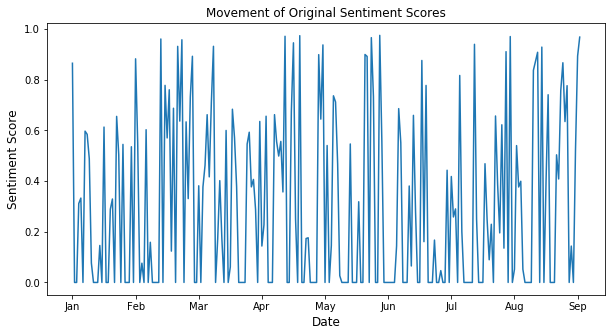

In [143]:
plt.figure(figsize=(10,5))
plt.plot(original_scores_name)
plt.title("Movement of Original Sentiment Scores")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(range(0,250,30), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']);

We can also take a look at the distribution at all the scores. There are roughly half of days that do not have a sentiment score.

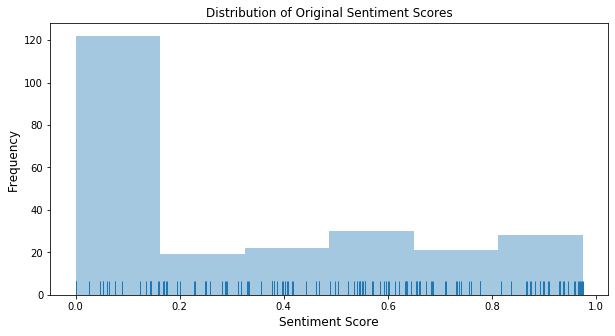

In [144]:
plt.figure(figsize=(10,5))
sns.distplot(original_scores_name,  kde=False, rug=True)
plt.title("Distribution of Original Sentiment Scores")
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12);

Here, I use the “one-sided” kernel smooth method to work around this issue and to comply with the actual situation.

In real life, it is not the case that a news only has effect to the performance of the stock on the single particular day that this news is published. Instead, its influence should last for a couple of days and gradually decay to zero.

Three different kinds of kernels are implemented and are ready to be further tested upon.

One thing that is obviously different from the traditional kernel smooth method is that the kernel I implemented here is single sided rather than two sided.

In [132]:
def kernel_density(kind, width, distance):
    if distance > width:
        return 0
    if kind == 'uniform':
        return 1 / width
    if kind == 'square':
        return 1.5 * (1 - math.pow((distance/width) ,2)) / width
    if kind == 'triangular':
        return 2 * (1 - (distance/width))/ width
    
# Hypter Parameter Width indicates the maximum period that a news has effect to the stock performace    
    
def kernel_smooth(original_scores, smooth_kind):
    smoothed_scores = [0] * len(original_scores)
    for i in range(len(original_scores)):
        for j in range(i, len(smoothed_scores)):
            smoothed_scores[j] += original_scores[i] * kernel_density(kind=smooth_kind, width=10, distance=math.fabs(j-i))
    return smoothed_scores

In [133]:
smoothed_scores_name = kernel_smooth(original_scores_name, 'square')
smoothed_scores_name[:10]

[0.1297005,
 0.12840349499999998,
 0.12451247999999998,
 0.1647247240909091,
 0.20509828739999997,
 0.1915251286172727,
 0.26295822303272726,
 0.3270610026463636,
 0.3695895983781817,
 0.34152566477318186]

We can plot the smoothed scores and the result is not only much more desirable but also more realistic when considering real life situation.

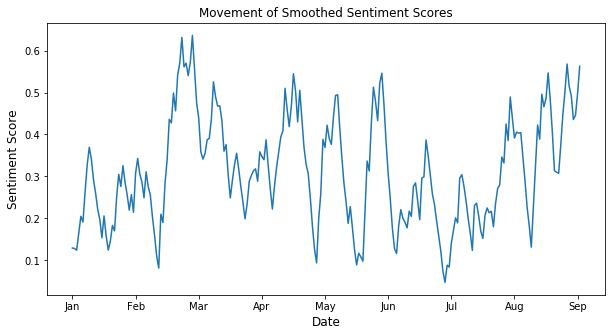

In [141]:
plt.figure(figsize=(10,5))
plt.plot(smoothed_scores_name)
plt.title("Movement of Smoothed Sentiment Scores")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(range(0,250,30), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']);

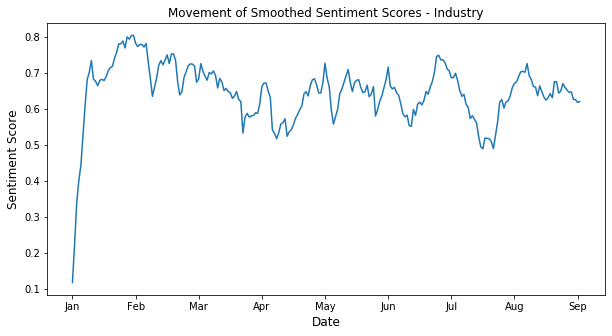

In [140]:
grouped_industry = industry_sentiment_result.groupby('date')[['sentiment_score']].mean()
date_to_score_industry = list(grouped_industry.to_dict().values())[0]
days = [day.strftime('%Y-%m-%d') for day in daterange(date(2019,1,1), date(2019,8,31))]
original_scores_industry = [date_to_score_industry[day] if day in date_to_score_industry else 0 for day in days]
smoothed_scores_industry = kernel_smooth(original_scores_industry, 'square')
plt.figure(figsize=(10,5))
plt.plot(smoothed_scores_industry)
plt.title("Movement of Smoothed Sentiment Scores - Industry")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(range(0,250,30), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']);

One observation from the above plot is that the curve experiences a somewhat peculiar sharp increase at the beginning.

This can be explained since the for first 10 (or whatever the width we set) days, their scores should come from the  10 days prior to the starting date of our entire news data set, which is of course, missing.

Therefore, this sudden increase is actually quite reasonable and suggest that we should exclude the first 10 days from our training.

## 4 - Market Data Collection and Input Preparation

Still using the first stock in our list, 000001, 万科, as an example, we retrieve the daily market data (open prices, close prices, high, low, ...) for the concerned period.

In [152]:
market_data = pro.daily(ts_code='000001.SZ', start_date='20190101', end_date='20190831')
market_data.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20190830,14.29,14.39,14.10,14.16,14.13,0.03,0.2123,798500.57,1136119.659
1,000001.SZ,20190829,14.22,14.24,14.08,14.13,14.27,-0.14,-0.9811,609034.34,861177.482
2,000001.SZ,20190828,14.26,14.28,14.05,14.27,14.31,-0.04,-0.2795,829657.68,1176329.095
3,000001.SZ,20190827,14.36,14.48,14.24,14.31,14.25,0.06,0.4211,1356713.37,1948127.123
4,000001.SZ,20190826,14.42,14.50,14.15,14.25,14.65,-0.40,-2.7304,1415122.54,2018498.039


At this stage, for this particular stock, we have actually acquired all input data. All there left to do is to sort them through and build a dataframe for furthur training and testing.

However, before doing that, several important simplifications and assumptions need to be made:

1) What we are trying to predict here is only the **percentage change** of some particular stock within one particular trading day. We consider this as a key measurement for how well the stock is performing and as an indicator for our trading strategy in later sections. 
<br/>Everything else including open price, close price and trading volume is regarded as side information and not predicted. (Some of them might be used for prediction, though.) 

2) We assume that the performance of a stock is related to only the **recent** news and recent stock market data.
<br/> For now, we define the word "recent" as "last three trading days" for market data and "last three days" for news.
<br/> Of course, such assumption and definition is extremely arbitrary and is subject to possible great future changes to improve the performance of models.

3) We furthur simplify the market data at each day to three numbers: open price, percentage change and trading volume.
<br/> Close prices are omitted here since it can be derived directly from open prices and percent changes.

To begin with, we start off simple and easy, we only use recent news sentiment scores (and not include recent market data) to predict the percent change of trading days.

Nevertheless, as other market data might be used for future model complication, we prepare 16 numbers (namely the open prices, percent changes and trading volumes of the previous three trading days and sentiment scores of the news in the past three days from both name-specific news and industry-specific news, plus 1 for output, i.e., percentage change on that day) for each and every trading day from the beginning of January to the end of August.

To accomplish this task, we need to create five dictionaries first.

In [201]:
# Two dictionaries for sentiment scores

name_score_dict = {}
industry_score_dict = {}

for i in range(242):
    day = date(2019,1,1) + timedelta(i)
    name_score_dict[day.strftime('%Y%m%d')] = smoothed_scores_name[i]
    industry_score_dict[day.strftime('%Y%m%d')] = smoothed_scores_industry[i]

NameError: name 'smoothed_scores_name' is not defined

In [158]:
# Three dictionaries for stock open prices and percent changes

market_data_date_indexed = market_data.set_index('trade_date')

open_price_dict = {}
percent_change_dict = {}
vol_dict = {}

for i in range(242):
    day_str = (date(2019,1,1) + timedelta(i)).strftime('%Y%m%d')
    if day_str in list(market_data_date_indexed.index):
        open_price_dict[day_str] = market_data_date_indexed.loc[day_str, 'open'] 
        percent_change_dict[day_str] = market_data_date_indexed.loc[day_str, 'pct_chg'] 
        vol_dict[day_str] = market_data_date_indexed.loc[day_str, 'vol'] 

Then, we start building the final dataframe.

In [181]:
final_dataframe = pd.DataFrame(columns = ['open-1', 'open-2', 'open-3', 'pctchg-1', 'pctchg-2', 'pctchg-3', 
                                          'vol-1', 'vol-2', 'vol-3',
                                          'name-1', 'name-2', 'name-3', 'industry-1', 'indutrys-2', 'industry-3',
                                          'pctchg-0'])

In [182]:
trading_days = list(open_price_dict.keys())

def previous_trading_day(today):
    result = today - timedelta(1)
    while not result.strftime('%Y%m%d') in trading_days:
        result = result - timedelta(1)
    return result

previous_trading_day(date(2019,2,10))

datetime.date(2019, 2, 1)

In [183]:
# Truncate the days from the 6th place, which is 20190110, as suggested by 3.2.4

for day in list(open_price_dict.keys())[6:]:
    tradeday1 = previous_trading_day(datetime.datetime.strptime(day, '%Y%m%d'))
    tradeday2 = previous_trading_day(tradeday1)
    tradeday3 = previous_trading_day(tradeday2)
    open1 = open_price_dict[tradeday1.strftime('%Y%m%d')]
    open2 = open_price_dict[tradeday2.strftime('%Y%m%d')]
    open3 = open_price_dict[tradeday3.strftime('%Y%m%d')]
    vol1 = vol_dict[tradeday1.strftime('%Y%m%d')]
    vol2 = vol_dict[tradeday2.strftime('%Y%m%d')]
    vol3 = vol_dict[tradeday3.strftime('%Y%m%d')]
    pctchg1 = percent_change_dict[tradeday1.strftime('%Y%m%d')]
    pctchg2 = percent_change_dict[tradeday2.strftime('%Y%m%d')]
    pctchg3 = percent_change_dict[tradeday3.strftime('%Y%m%d')]
    
    previous_name_scores = [name_score_dict[(datetime.datetime.strptime(day, '%Y%m%d')-timedelta(i)).strftime('%Y%m%d')] 
                            for i in range(1,4)]
    previous_industry_scores = [industry_score_dict[(datetime.datetime.strptime(day, '%Y%m%d')-timedelta(i)).strftime('%Y%m%d')] 
                                for i in range(1,4)]
    
    data = [open1, open2, open3, pctchg1, pctchg2, pctchg3, vol1, vol2, vol3] + previous_name_scores + previous_industry_scores + [percent_change_dict[day]]
            
    final_dataframe.loc[day] = data

In [184]:
print(final_dataframe.shape)
final_dataframe.head()

(157, 16)


,open-1,open-2,open-3,pctchg-1,pctchg-2,pctchg-3,vol-1,vol-2,vol-3,name-1,name-2,name-3,industry-1,indutrys-2,industry-3,pctchg-0
20190110,9.74,9.73,9.84,2.8986,-0.8214,-0.1026,1233486.36,402388.11,865687.66,0.369590,0.327061,0.262958,0.701542,0.680709,0.607741,1.6097
20190111,9.87,9.74,9.73,1.6097,2.8986,-0.8214,1071817.66,1233486.36,402388.11,0.341526,0.369590,0.327061,0.734110,0.701542,0.680709,0.9901
20190114,10.11,9.87,9.74,0.9901,1.6097,2.8986,696364.55,1071817.66,1233486.36,0.221808,0.260669,0.292360,0.664182,0.676530,0.682409,-0.8824
20190115,10.22,10.11,9.87,-0.8824,0.9901,1.6097,500443.59,696364.55,1071817.66,0.197657,0.221808,0.260669,0.679139,0.664182,0.676530,1.2859
20190116,10.11,10.22,10.11,1.2859,-0.8824,0.9901,542160.55,500443.59,696364.55,0.154045,0.197657,0.221808,0.681913,0.679139,0.664182,2.3438


## 5 - Building and Applying the Data Preparation Pipeline

Now, we have gone through the entire process of preparing the input and output data for one stock.

Since eventually we will need to prepare such data for each and every stock from the fifty stocks of interest, it would greatly ease our life if we define several functions to modularize the whole process and build a pipeline for this data preparation process.

In [185]:
def filter_news(keyword):
    return news_aggregated[news_aggregated['content'].str.contains(keyword).fillna(value=False)]

def sort_by_date(df):
    df['date'] = df['datetime'].apply(lambda x: x[:10])
    df = df.sort_values('date').drop('datetime', axis=1)
    return df
    
def get_sentiment_score(df, keyword):
    save_path = 'sentiment_result/' + keyword + '.csv'
    if not Path(save_path).is_file():
        temp_list = []
        for news in df['content']:
            temp_list.append(sentiment_score(news))
        df['sentiment_score'] = temp_list
        to_return = df[['date', 'sentiment_score', 'content', 'source']]
        to_return.to_csv(save_path)
        return to_return
    else:
        to_return = pd.read_csv(save_path)
        return to_return
    
def get_smoothed_score(df):
    grouped = df.groupby('date')[['sentiment_score']].mean()
    date_to_score = list(grouped.to_dict().values())[0]
    days = [day.strftime('%Y-%m-%d') for day in daterange(date(2019,1,1), date(2019,8,31))]
    original_scores = [date_to_score[day] if day in date_to_score else 0 for day in days]
    smoothed_scores = kernel_smooth(original_scores, 'square')
    return smoothed_scores
    
def build_five_dicts(market_data, smoothed_scores_name, smoothed_scores_industry):
    name_score_dict = {}
    industry_score_dict = {}
    open_price_dict = {}
    percent_change_dict = {}
    vol_dict = {}
    market_data_date_indexed = market_data.set_index('trade_date')
    for i in range(242):
        day = date(2019,1,1) + timedelta(i)
        day_str = day.strftime('%Y%m%d')
        name_score_dict[day.strftime('%Y%m%d')] = smoothed_scores_name[i]
        industry_score_dict[day.strftime('%Y%m%d')] = smoothed_scores_industry[i]
        if day_str in list(market_data_date_indexed.index):
            open_price_dict[day_str] = market_data_date_indexed.loc[day_str, 'open'] 
            percent_change_dict[day_str] = market_data_date_indexed.loc[day_str, 'pct_chg'] 
            vol_dict[day_str] = market_data_date_indexed.loc[day_str, 'vol'] 
    return name_score_dict, industry_score_dict, open_price_dict, percent_change_dict, vol_dict

def previous_trading_day(today, trading_days):
    result = today - timedelta(1)
    while not result.strftime('%Y%m%d') in trading_days:
        result = result - timedelta(1)
    return result

def build_final_dataframe(name_score_dict, industry_score_dict, open_price_dict, percent_change_dict, vol_dict):
    final_dataframe = pd.DataFrame(columns = ['open-1', 'open-2', 'open-3', 'pctchg-1', 'pctchg-2', 'pctchg-3', 
                                              'vol-1', 'vol-2', 'vol-3',
                                              'name-1', 'name-2', 'name-3', 'industry-1', 'industry-2', 'industry-3',
                                              'pctchg-0'])
    for day in list(open_price_dict.keys())[6:]:
        trading_days = list(open_price_dict.keys())
        tradeday1 = previous_trading_day(datetime.datetime.strptime(day, '%Y%m%d'), trading_days)
        tradeday2 = previous_trading_day(tradeday1, trading_days)
        tradeday3 = previous_trading_day(tradeday2, trading_days)
        open1 = open_price_dict[tradeday1.strftime('%Y%m%d')]
        open2 = open_price_dict[tradeday2.strftime('%Y%m%d')]
        open3 = open_price_dict[tradeday3.strftime('%Y%m%d')]
        pctchg1 = percent_change_dict[tradeday1.strftime('%Y%m%d')]
        pctchg2 = percent_change_dict[tradeday2.strftime('%Y%m%d')]
        pctchg3 = percent_change_dict[tradeday3.strftime('%Y%m%d')]
        vol1 = vol_dict[tradeday1.strftime('%Y%m%d')]
        vol2 = vol_dict[tradeday2.strftime('%Y%m%d')]
        vol3 = vol_dict[tradeday3.strftime('%Y%m%d')]
        previous_name_scores = [name_score_dict[(datetime.datetime.strptime(day, '%Y%m%d')-timedelta(i)).strftime('%Y%m%d')] 
                                for i in range(1,4)]
        previous_industry_scores = [industry_score_dict[(datetime.datetime.strptime(day, '%Y%m%d')-timedelta(i)).strftime('%Y%m%d')] 
                                    for i in range(1,4)]
        data = [open1, open2, open3, pctchg1, pctchg2, pctchg3, vol1, vol2, vol3] + previous_name_scores + previous_industry_scores + [percent_change_dict[day]]
        final_dataframe.loc[day] = data
    return final_dataframe

After all functions been defined for each step along the way, we can simply define another function to summarize the whole process, within which we call those functions defined above and meanwhile deal with some tiny details that may cause error.

In [186]:
def build_dataframe(i):
    
    # Filter the 380k news and extract those related to either this particular stock or industry
    name_appeared = filter_news(stock_names_chn[i])
    industry_appeared = filter_news(stock_industries[i])
    
    # Sort According to Date
    name_appeared = sort_by_date(name_appeared)
    industry_appeared = sort_by_date(industry_appeared)
        
    # Get sentiment scores for name appeared news and industry appeared news
    name_sentiment_result = get_sentiment_score(name_appeared, stock_names_chn[i])
    industry_sentiment_result = get_sentiment_score(industry_appeared, stock_industries[i])
    
    # Get smoothed scores
    smoothed_scores_name = get_smoothed_score(name_sentiment_result)
    smoothed_scores_industry = get_smoothed_score(industry_sentiment_result)
    
    # Get Five Dicts and Build Dataframe
    market_data = pro.daily(ts_code=stock_codes[i]+'.SZ', start_date='20190101', end_date='20190831')
    if market_data.shape[0] == 0:
        market_data = pro.daily(ts_code=stock_codes[i]+'.SH', start_date='20190101', end_date='20190831')
    final_dataframe = build_final_dataframe(*build_five_dicts(market_data, smoothed_scores_name, smoothed_scores_industry))
    
    final_dataframe.to_csv('final_dataframe/' + str(i) + '.csv')
    
    return final_dataframe

Finally, we call the above function for each stock and get a data matrix that we save locally for the model training and testing in the next section.

In [187]:
for i in range(50):
    build_dataframe(i)

/Users/tianhaozhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## 6 - Training and Validating Models

As mentioned in section 4, the very first thing we try is using recent news sentiment scores (6 numbers) to try to predict the percent change of trading days.

In [64]:
import sklearn
from sklearn import linear_model
from keras import Model
from sklearn import model_selection

### 6.1 - Universal Model - Linear Regression

Based on the thought that the underlying logic of using recent news and market data to predict current stock performance should be homogenous rather than heterogenous for different stocks, the first attempt is aggregating all data from all stocks first and then training a universal model for prediction.

First, we read from the csv files we saved locally and aggregate them to get the matrix to begin with the training and testing process.

In [128]:
l = []
for i in range(50):
    l.append(pd.read_csv('final_dataframe/'+str(i)+'.csv'))
all_data = pd.concat(l)
print(all_data.shape)
all_data.head()

(7828, 17)


,Unnamed: 0,open-1,open-2,open-3,pctchg-1,pctchg-2,pctchg-3,vol-1,vol-2,vol-3,name-1,name-2,name-3,industry-1,industry-2,industry-3,pctchg-0
0,20190110,25.40,25.05,25.29,1.3200,-0.1996,0.4813,340140.62,214382.02,427154.85,0.369590,0.327061,0.262958,0.701542,0.680709,0.607741,-0.8685
1,20190111,25.22,25.40,25.05,-0.8685,1.3200,-0.1996,224649.20,340140.62,214382.02,0.341526,0.369590,0.327061,0.734110,0.701542,0.680709,0.7567
2,20190114,25.10,25.22,25.40,0.7567,-0.8685,1.3200,240694.90,224649.20,340140.62,0.221808,0.260669,0.292360,0.664182,0.676530,0.682409,-1.1067
3,20190115,25.13,25.10,25.22,-1.1067,0.7567,-0.8685,183281.34,240694.90,224649.20,0.197657,0.221808,0.260669,0.679139,0.664182,0.676530,0.5596
4,20190116,25.00,25.13,25.10,0.5596,-1.1067,0.7567,368758.85,183281.34,240694.90,0.154045,0.197657,0.221808,0.681913,0.679139,0.664182,1.0334


Then, we obtain the input matrix and the output vector and split the data randomly into the training set and the testing set.

There are 7828 data points in total, we shuffle the data and randomly split into training set and testing set with the ratio of 4:1.

Then, a linear regression is fitted on the training data and tested on the testing data.

In [129]:
X = all_data.iloc[:,-7:-1]
y = all_data.iloc[:, 16]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [130]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr_all = linear_model.LinearRegression()

regr_all.fit(X_train, y_train)

y_pred = regr_all.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 3.85


There are 7828 data points in total, we shuffle the data and randomly split into training set and testing set with the ratio of 4:1.

Then, a linear regression is fitted on the training data and tested on the testing data.


Here, to visualize how accurate our prediction after the entire dataset being randomly shuffled, we create a "virtual stock" by simulating its actual price using actual percentage change data (which comes from different stocks and is not sorted in chronological order) and simulating its predicted price using corresponding predicted percentage changes.

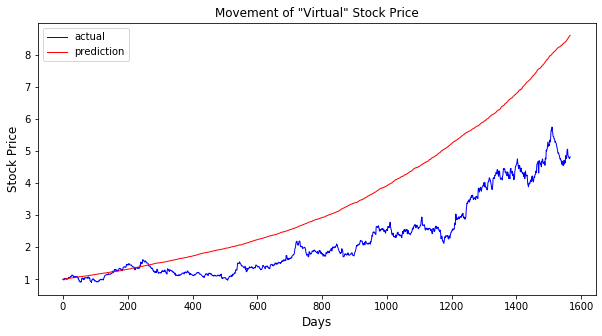

In [131]:
x = 1

p_actual = [1]
p_pred = [1]

for y_t in y_test:
    p_actual.append(p_actual[-1] * (1+(0.01*y_t)))     
for y_p in y_pred:
    p_pred.append(p_pred[-1] * ((0.01*y_p)+1))
    
plt.figure(figsize=(10,5))
plt.title("Movement of \"Virtual\" Stock Price")
plt.xlabel('Days', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)     
plt.plot(p_actual, linewidth=1, color='blue', label='actual')
plt.plot(p_pred, linewidth=1, color='red', label='prediction')
plt.legend();

We can see that although the prediction can somewhat capture the main trend (going up) of the actual movement, clearly it appears way too stable compared to the actual fluctuation of stock prices.

The reason is probably that we have used 6k~7k data points to train a linear regression with only 6 features. It is thus reasonable that we end up with the prediction algorithm being inordinately "conservative", in the sense that it will always predict a gentle, steady, slow increase no matter what input is given.

### 6.2 - Individual Model - Linear Regression

#### 6.2.1 – Percentage Change Prediction Results
Seeing that the result of training one universal model after aggregating data from all stocks is not that desirable, we try a different approach and train individual models for each stock.
Again, we use the simplest linear regression model, but instead of training one model over 7828 data points, we train 50 models, each over around 130 data points.

Here, since the testing set contains only around 30 data points, we can actually plot the predicted percentage changes and compare to the actual numbers. (Note that this is not possible in the previous section since 1000 data points would be too versatile can no meaningful conclusion can be drawn).

So, we compare the actual percentage changes, the predicted percentage changes using universal model and the percentage changes using the individual model.

In [132]:
def linear_regress_predict(data_i): 
    training_size = int(data_i.shape[0] * 0.8)
    training_X_i = data_i.iloc[:training_size, -7:-1]
    training_y_i = data_i.iloc[:training_size, -1]
    testing_X_i = data_i.iloc[training_size:, -7:-1]
    testing_y_i = data_i.iloc[training_size:, -1]
    regri = linear_model.LinearRegression()
    regri.fit(training_X_i, training_y_i)
    # Using the model trained on this stock to predict
    y_pred_i_i = regri.predict(testing_X_i)
    # Using the model trained on all stocks to predict
    y_pred_i_all = regr_all.predict(testing_X_i)
    return y_pred_i_i, y_pred_i_all, regri

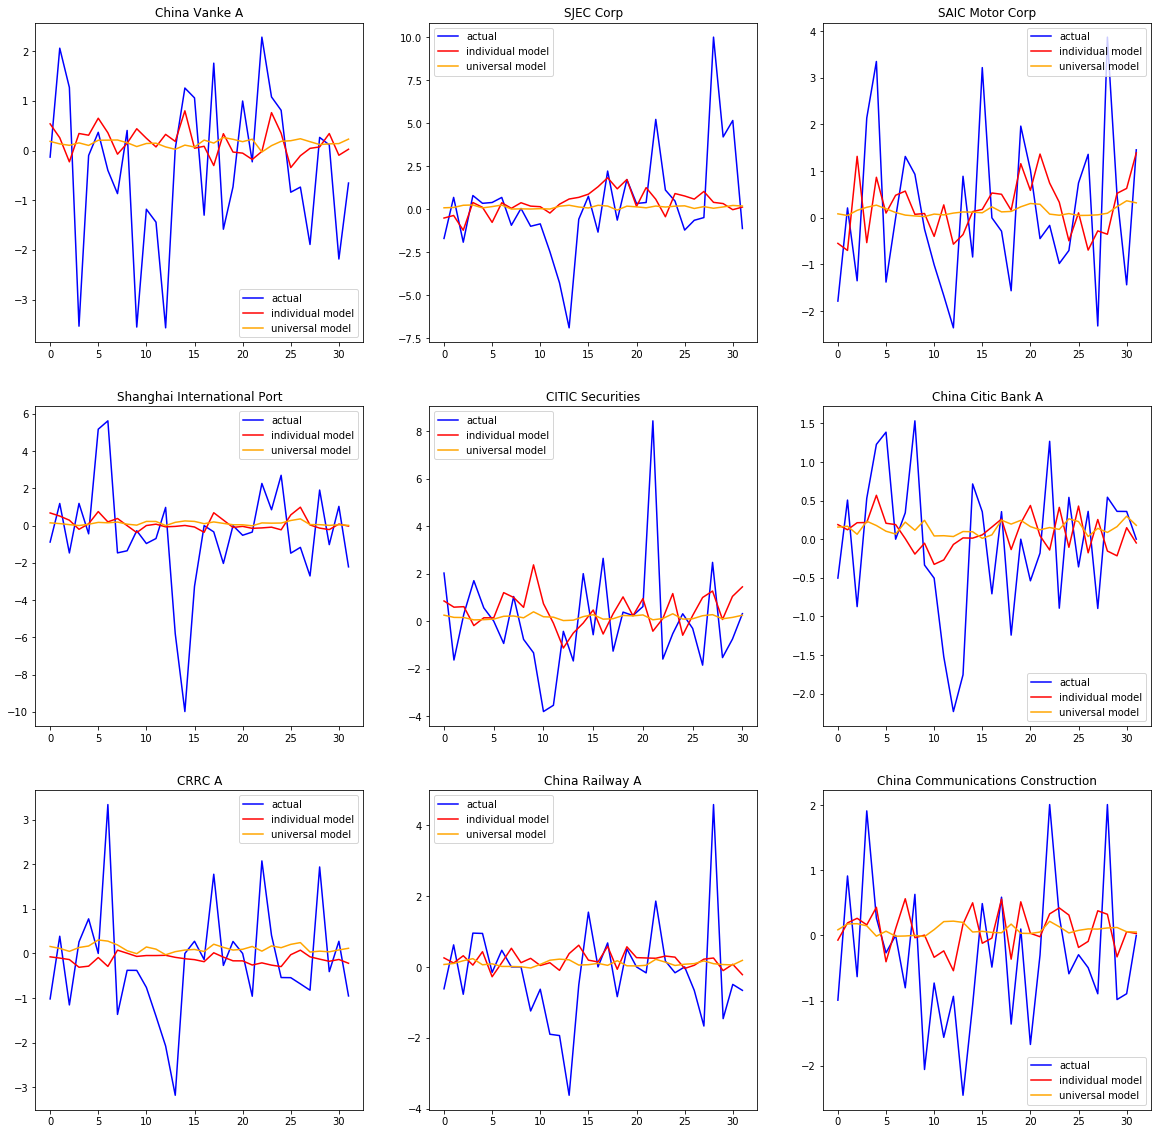

In [133]:
fig, axs = plt.subplots(3,3, figsize=(20,20))

for i in range(9):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    training_size = int(data_i.shape[0] * 0.8)
    actual_pctchg_i = list(data_i.iloc[training_size:].loc[:,'pctchg-0'])
    y_pred_i_i, y_pred_i_all, _ = linear_regress_predict(data_i)
    axs[int(i/3)][i%3].set_title(stock_names_eng[i])
    axs[int(i/3)][i%3].plot(actual_pctchg_i, linewidth=1.5, color='blue', label='actual')
    axs[int(i/3)][i%3].plot(y_pred_i_i, linewidth=1.5, color='red', label='individual model')
    axs[int(i/3)][i%3].plot(y_pred_i_all, linewidth=1.5, color='orange', label='universal model')
    axs[int(i/3)][i%3].legend()
plt.savefig('fig/1.png')
plt.show();

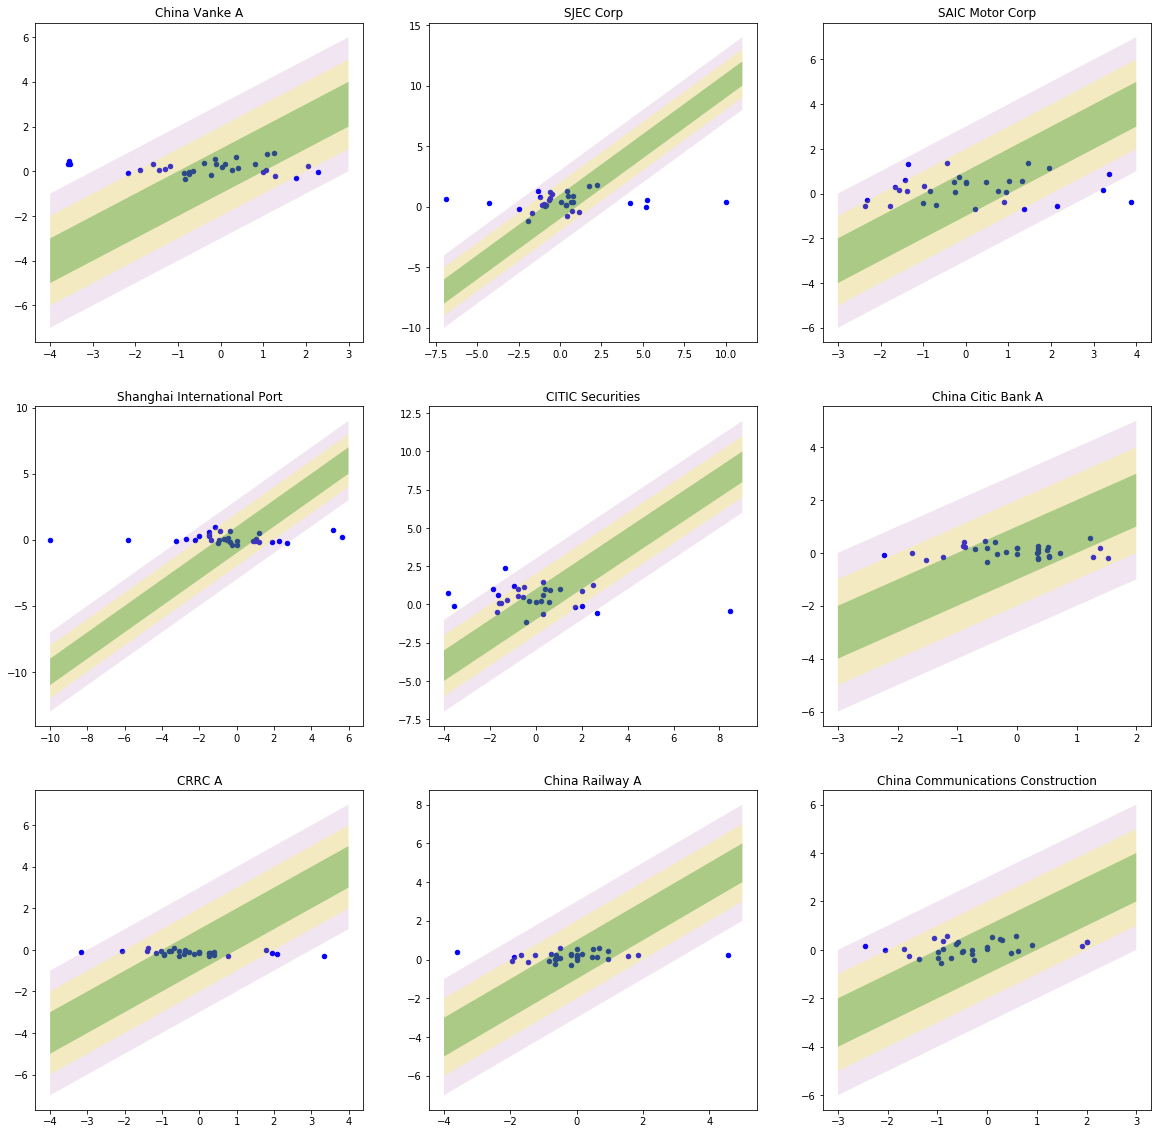

In [136]:
fig, axs = plt.subplots(3,3, figsize=(20,20))

for i in range(9):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    training_size = int(data_i.shape[0] * 0.8)
    actual_pctchg_i = list(data_i.iloc[training_size:].loc[:,'pctchg-0'])
    y_pred_i_i, y_pred_i_all, _ = linear_regress_predict(data_i)
    axs[int(i/3)][i%3].set_title(stock_names_eng[i])
    axs[int(i/3)][i%3].scatter(actual_pctchg_i, y_pred_i_i, color='blue', s=20)
    min_value = int(min(min(actual_pctchg_i), min(y_pred_i_i)))-1
    max_value = int(max(max(actual_pctchg_i), max(y_pred_i_i)))+2
    axs[int(i/3)][i%3].fill_between(range(min_value, max_value), range(min_value-3, max_value-3), range(min_value+3, max_value+3), facecolor='purple', alpha=0.1)
    axs[int(i/3)][i%3].fill_between(range(min_value, max_value), range(min_value-2, max_value-2), range(min_value+2, max_value+2), facecolor='yellow', alpha=0.2)
    axs[int(i/3)][i%3].fill_between(range(min_value, max_value), range(min_value-1, max_value-1), range(min_value+1, max_value+1), facecolor='green', alpha=0.3)
plt.savefig('fig/2.png')
plt.show();

We can observe that the individual model is clearly better than the universal model generally speaking. It is indeed capable of capturing some of those fluctuations.

However, both predicted results are too “stable”, there are way less fluctuations and variance in the predicted percentage changes compared to the actual situation.

Another thing is that the changes predicted using individual model appears to be one or two days “later” than actual changes, which is also reasonable due to the untimeliness nature of nature.

The stock may respond immediately to events, market emotions and public opinions, but it would take time for the corresponding news to be created, edited, published and then used to predict prices.

Given that our model only uses news in the previous three days (not inclusive of today) to predict the percentage change today (which is sensible since you cannot know the news today in advance), this result is anticipated.

#### 6.2.2 – Price Movement Prediction Result

Here, because during the training of individual model, no random shuffling is performed on the dataset and chronological order is reserved, the testing data is actually the set of some consecutive trading days. 
Therefore, we can actually compare the “calculated price using predicted percentage change” to the actual price movements of any particular stock.

Note that while the blue line is the actual price movement, there is also an orange line, which is the price movement calculated using percentage changes in each trading day (in other words, changes from close price day one to open price day two are all considered noise and removed). 

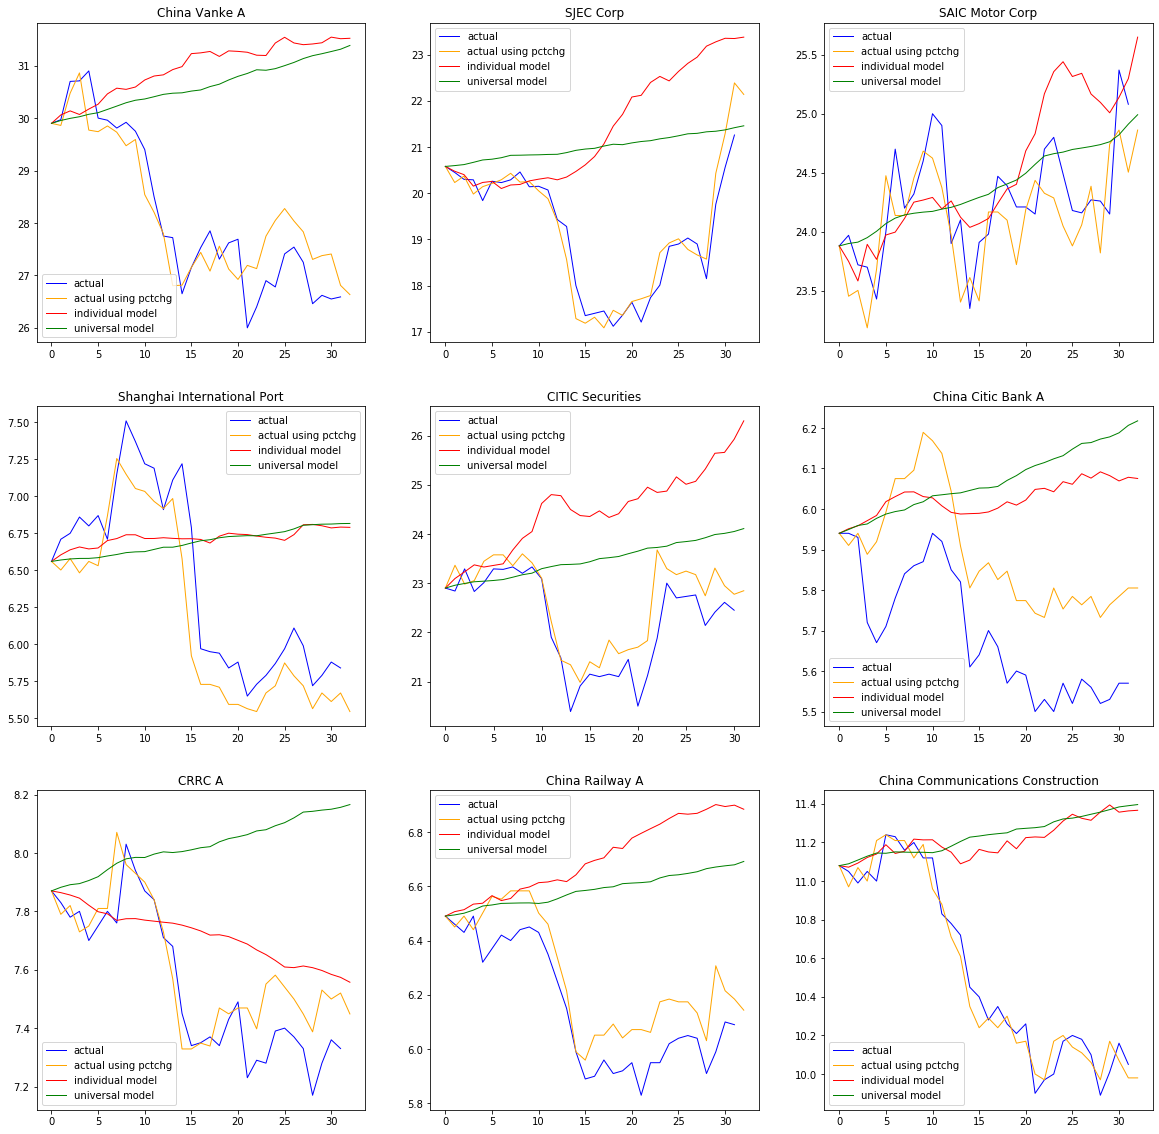

In [146]:
fig, axs = plt.subplots(3,3, figsize=(20,20))

for i in range(9):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    training_size = int(data_i.shape[0] * 0.8)
    actual_price_i = list(data_i.iloc[training_size:].loc[:,'open-1'])
    actual_pctchg_i = list(data_i.iloc[training_size:].loc[:,'pctchg-0'])
    predicted_price_i_i = [actual_price_i[0]]
    predicted_price_i_all = [actual_price_i[0]]
    actual_using_pct_i = [actual_price_i[0]]
    y_pred_i_i, y_pred_i_all, _ = linear_regress_predict(data_i)
    for pctchg in actual_pctchg_i:
        actual_using_pct_i.append(actual_using_pct_i[-1] * (1+(0.01*pctchg)))
    for pctchg in list(y_pred_i_i):
        predicted_price_i_i.append(predicted_price_i_i[-1] * (1+(0.01*pctchg)))
    for pctchg in list(y_pred_i_all):
        predicted_price_i_all.append(predicted_price_i_all[-1] * (1+(0.01*pctchg)))
    axs[int(i/3)][i%3].set_title(stock_names_eng[i])
    axs[int(i/3)][i%3].plot(actual_price_i, linewidth=1, color='blue', label='actual')
    axs[int(i/3)][i%3].plot(actual_using_pct_i, linewidth=1, color='orange', label='actual using pctchg')
    axs[int(i/3)][i%3].plot(predicted_price_i_i, linewidth=1, color='red', label='individual model')
    axs[int(i/3)][i%3].plot(predicted_price_i_all, linewidth=1, color='green', label='universal model')
    axs[int(i/3)][i%3].legend();
    
plt.savefig('fig/3.png')
plt.show();

We can see that though the individual model may be slightly better, both models actually perform quite badly when we draw out the price movement curve.

One explanation of this would be that our prediction solely focuses on percentage changes. And any error, any deviation from the actual changes would be accumulated and then “amplified” in a sort of exponential way.

## 7 - Using Model to Actually Trade

Although our model is very naïve, simple and inaccurate, we implement the trading simulation and see its performance anyways.

The trading simulation is pretty straight-forward and goes like the following:

Since the entire August is well within the testing dataset of individual models for all stocks, we can use the model to trade daily in August.
<br/> We start with 1 million RMB, for each day, we predict the percentage changes for all 50 stocks, choose the top N stocks, buy them at open prices and sell them close prices each day.
<br/> We always all-in with whatever we and further assume that our fund is split equally on the N stocks that we buy each buy.
<br/> In the end, we check how much money we have left in our fund.

Note that N=50 means we basically buy all stocks with equal funding every day and is set as a standard for comparison.

In [140]:
linear_models = []
market_datas = []

for i in range(50):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    market_datas.append(data_i)
    _, _, model_i = linear_regress_predict(data_i)
    linear_models.append(model_i)

In [144]:
import random
def get_ending_position(x):
    money = 100
    random_money = 100
    days = [day.strftime('%Y%m%d') for day in daterange(date(2019,8,1), date(2019,8,30))]
    for day in days:
        try:
            today_market = [market_datas[i].set_index(market_datas[i].columns[0]).loc[[int(day)], :] for i in range(50)]
            predicted_pctchgs = [linear_models[i].predict(today_market[i].iloc[:,-7:-1])[0] for i in range(50)]
            bought = sorted(range(50), key=lambda i: predicted_pctchgs[i], reverse=True)[:x]
            random_bought = random.sample(range(0, 50), x)
            actual_pctchgs_for_bought = [today_market[i].iloc[:,-1].values[0] for i in bought]
            actual_pctchgs_for_random = [today_market[i].iloc[:,-1].values[0] for i in random_bought]
            money *= (1 + 0.01 * np.mean(actual_pctchgs_for_bought))
            random_money *= (1 + 0.01 * np.mean(actual_pctchgs_for_random))
        except KeyError:
            pass
    return money, random_money

In [145]:
end_positions = [get_ending_position(x)[0] for x in range(1, 51)]
random_positions = [get_ending_position(x)[1] for x in range(1, 51)]

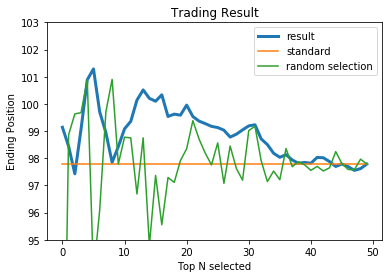

In [152]:
plt.title("Trading Result")
plt.xlabel('Top N selected')
plt.ylabel('Ending Position')
plt.plot(end_positions, linewidth=3, label='result')
plt.plot([end_positions[-1]]*50, label='standard')
plt.plot(random_positions, label='random selection')
plt.ylim((95,103))
plt.legend();
plt.savefig('fig/4.png')

In [153]:
def get_all_positions(x):
    money = [100]
    days = [day.strftime('%Y%m%d') for day in daterange(date(2019,8,1), date(2019,8,30))]
    for day in days:
        try:
            today_market = [market_datas[i].set_index(market_datas[i].columns[0]).loc[[int(day)], :] for i in range(50)]
            predicted_pctchgs = [linear_models[i].predict(today_market[i].iloc[:,-7:-1])[0] for i in range(50)]
            bought = sorted(range(50), key=lambda i: predicted_pctchgs[i], reverse=True)[:x]
            actual_pctchgs_for_bought = [today_market[i].iloc[:,-1].values[0] for i in bought]
            money.append( money[-1] * (1 + 0.01 * np.mean(actual_pctchgs_for_bought)))
        except KeyError:
            pass
    return money

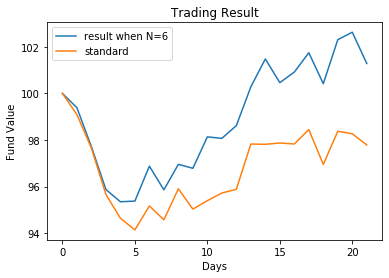

In [154]:
plt.title("Trading Result")
plt.xlabel('Days')
plt.ylabel('Fund Value')
plt.plot(get_all_positions(6), label='result when N=6')
plt.plot(get_all_positions(50), label='standard')
plt.legend();
plt.savefig('fig/5.png')

## 8 – Include History Market Data

Sticking with the simplest linear regression model, we try to include more features from the history market data for prediction this time.

This time, instead of only 6 sentiment scores, we use 15 numerical numbers for prediction. Namely, we use the open prices, percentage changes and trading volumes of previous three trading days and the six numbers already in use (news sentiment scores) to predict the percentage change today.

Basically, we use everything we prepared in the final dataframe (previously in section 5) to train and test a new linear regression model.

In [155]:
l = []
for i in range(50):
    l.append(pd.read_csv('final_dataframe/'+str(i)+'.csv'))
all_data = pd.concat(l)
print(all_data.shape)
all_data.head()

(7828, 17)


,Unnamed: 0,open-1,open-2,open-3,pctchg-1,pctchg-2,pctchg-3,vol-1,vol-2,vol-3,name-1,name-2,name-3,industry-1,industry-2,industry-3,pctchg-0
0,20190110,25.40,25.05,25.29,1.3200,-0.1996,0.4813,340140.62,214382.02,427154.85,0.369590,0.327061,0.262958,0.701542,0.680709,0.607741,-0.8685
1,20190111,25.22,25.40,25.05,-0.8685,1.3200,-0.1996,224649.20,340140.62,214382.02,0.341526,0.369590,0.327061,0.734110,0.701542,0.680709,0.7567
2,20190114,25.10,25.22,25.40,0.7567,-0.8685,1.3200,240694.90,224649.20,340140.62,0.221808,0.260669,0.292360,0.664182,0.676530,0.682409,-1.1067
3,20190115,25.13,25.10,25.22,-1.1067,0.7567,-0.8685,183281.34,240694.90,224649.20,0.197657,0.221808,0.260669,0.679139,0.664182,0.676530,0.5596
4,20190116,25.00,25.13,25.10,0.5596,-1.1067,0.7567,368758.85,183281.34,240694.90,0.154045,0.197657,0.221808,0.681913,0.679139,0.664182,1.0334


In [156]:
X = all_data.iloc[:,1:-1]
y = all_data.iloc[:, 16]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [157]:
regr_all = linear_model.LinearRegression()

regr_all.fit(X_train, y_train)

y_pred = regr_all.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 3.95


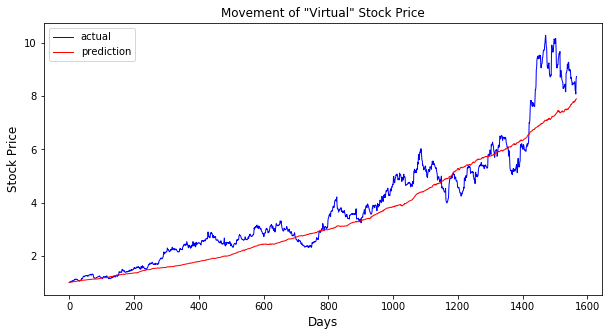

In [158]:
x = 1

p_actual = [1]
p_pred = [1]

for y_t in y_test:
    p_actual.append(p_actual[-1] * (1+(0.01*y_t)))     
for y_p in y_pred:
    p_pred.append(p_pred[-1] * ((0.01*y_p)+1))
    
plt.figure(figsize=(10,5))
plt.title("Movement of \"Virtual\" Stock Price")
plt.xlabel('Days', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)     
plt.plot(p_actual, linewidth=1, color='blue', label='actual')
plt.plot(p_pred, linewidth=1, color='red', label='prediction')
plt.legend();

In [159]:
def linear_regress_predict(data_i): 
    training_size = int(data_i.shape[0] * 0.8)
    training_X_i = data_i.iloc[:training_size, 1:-1]
    training_y_i = data_i.iloc[:training_size, -1]
    testing_X_i = data_i.iloc[training_size:, 1:-1]
    testing_y_i = data_i.iloc[training_size:, -1]
    regri = linear_model.LinearRegression()
    regri.fit(training_X_i, training_y_i)
    # Using the model trained on this stock to predict
    y_pred_i_i = regri.predict(testing_X_i)
    # Using the model trained on all stocks to predict
    y_pred_i_all = regr_all.predict(testing_X_i)
    return y_pred_i_i, y_pred_i_all, regri

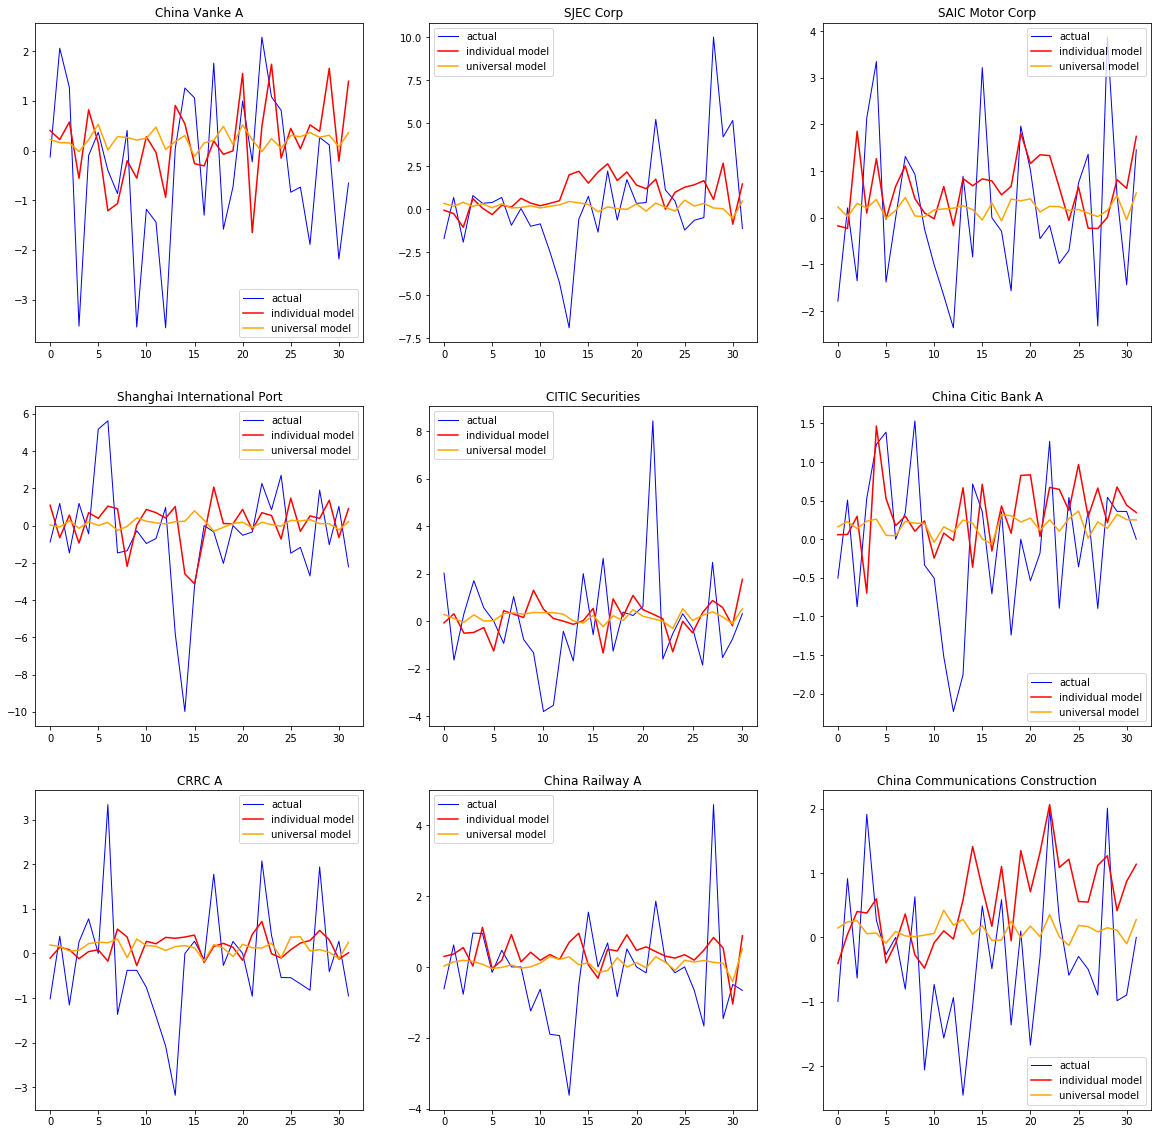

In [160]:
fig, axs = plt.subplots(3,3, figsize=(20,20))

for i in range(9):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    training_size = int(data_i.shape[0] * 0.8)
    actual_pctchg_i = list(data_i.iloc[training_size:].loc[:,'pctchg-0'])
    y_pred_i_i, y_pred_i_all, _ = linear_regress_predict(data_i)
    axs[int(i/3)][i%3].set_title(stock_names_eng[i])
    axs[int(i/3)][i%3].plot(actual_pctchg_i, linewidth=1, color='blue', label='actual')
    axs[int(i/3)][i%3].plot(y_pred_i_i, linewidth=1.5, color='red', label='individual model')
    axs[int(i/3)][i%3].plot(y_pred_i_all, linewidth=1.5, color='orange', label='universal model')
    axs[int(i/3)][i%3].legend()

plt.savefig('fig/6.png')
plt.show();

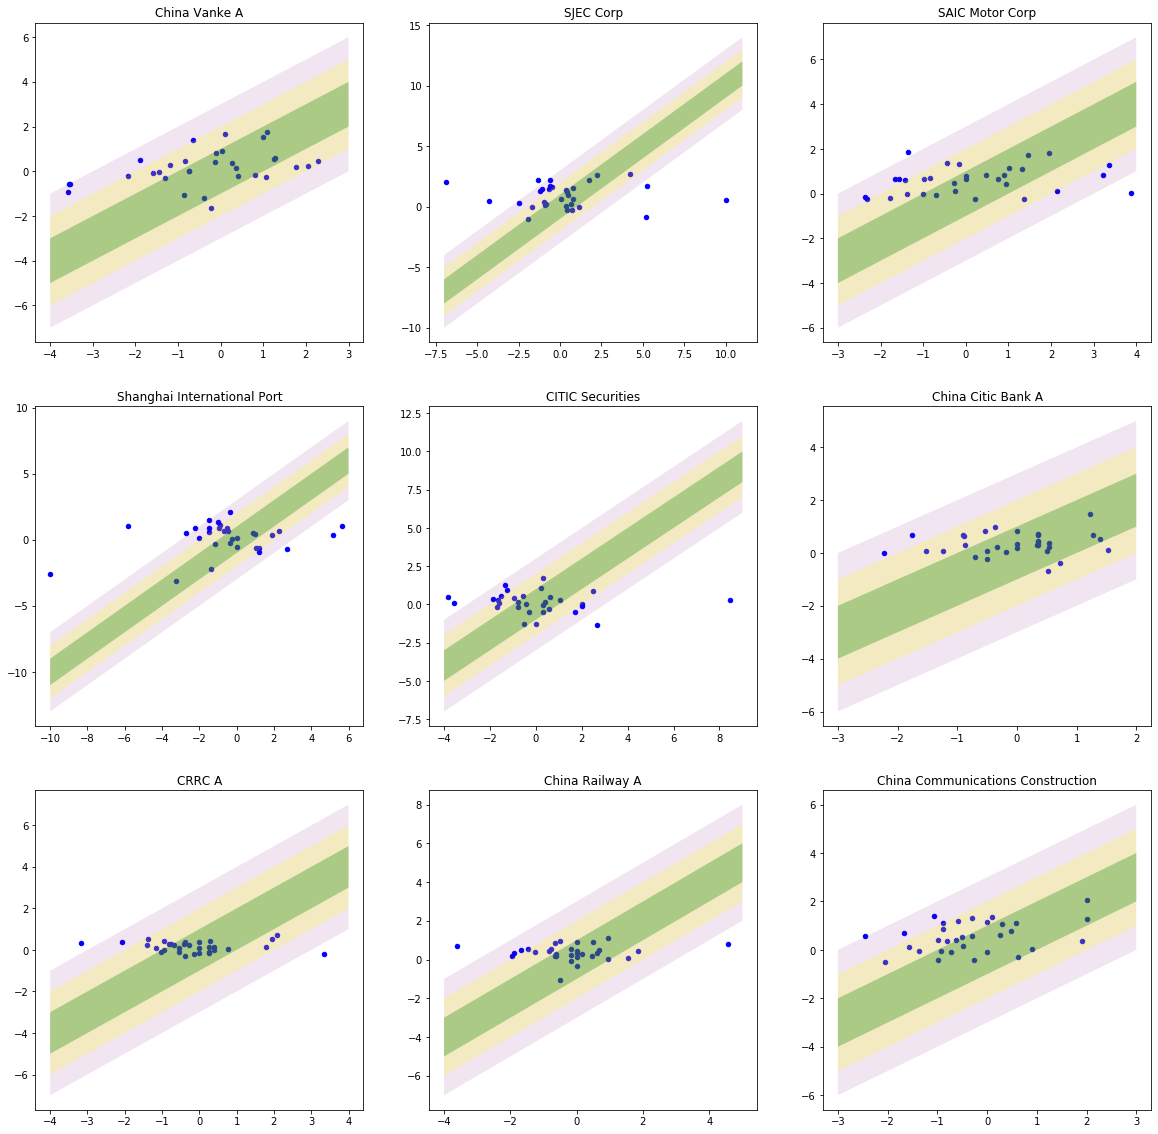

In [161]:
fig, axs = plt.subplots(3,3, figsize=(20,20))

for i in range(9):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    training_size = int(data_i.shape[0] * 0.8)
    actual_pctchg_i = list(data_i.iloc[training_size:].loc[:,'pctchg-0'])
    y_pred_i_i, y_pred_i_all, _ = linear_regress_predict(data_i)
    axs[int(i/3)][i%3].set_title(stock_names_eng[i])
    axs[int(i/3)][i%3].scatter(actual_pctchg_i, y_pred_i_i, color='blue', s=20)
    min_value = int(min(min(actual_pctchg_i), min(y_pred_i_i)))-1
    max_value = int(max(max(actual_pctchg_i), max(y_pred_i_i)))+2
    axs[int(i/3)][i%3].fill_between(range(min_value, max_value), range(min_value-3, max_value-3), range(min_value+3, max_value+3), facecolor='purple', alpha=0.1)
    axs[int(i/3)][i%3].fill_between(range(min_value, max_value), range(min_value-2, max_value-2), range(min_value+2, max_value+2), facecolor='yellow', alpha=0.2)
    axs[int(i/3)][i%3].fill_between(range(min_value, max_value), range(min_value-1, max_value-1), range(min_value+1, max_value+1), facecolor='green', alpha=0.3)
plt.savefig('fig/7.png')
plt.show();

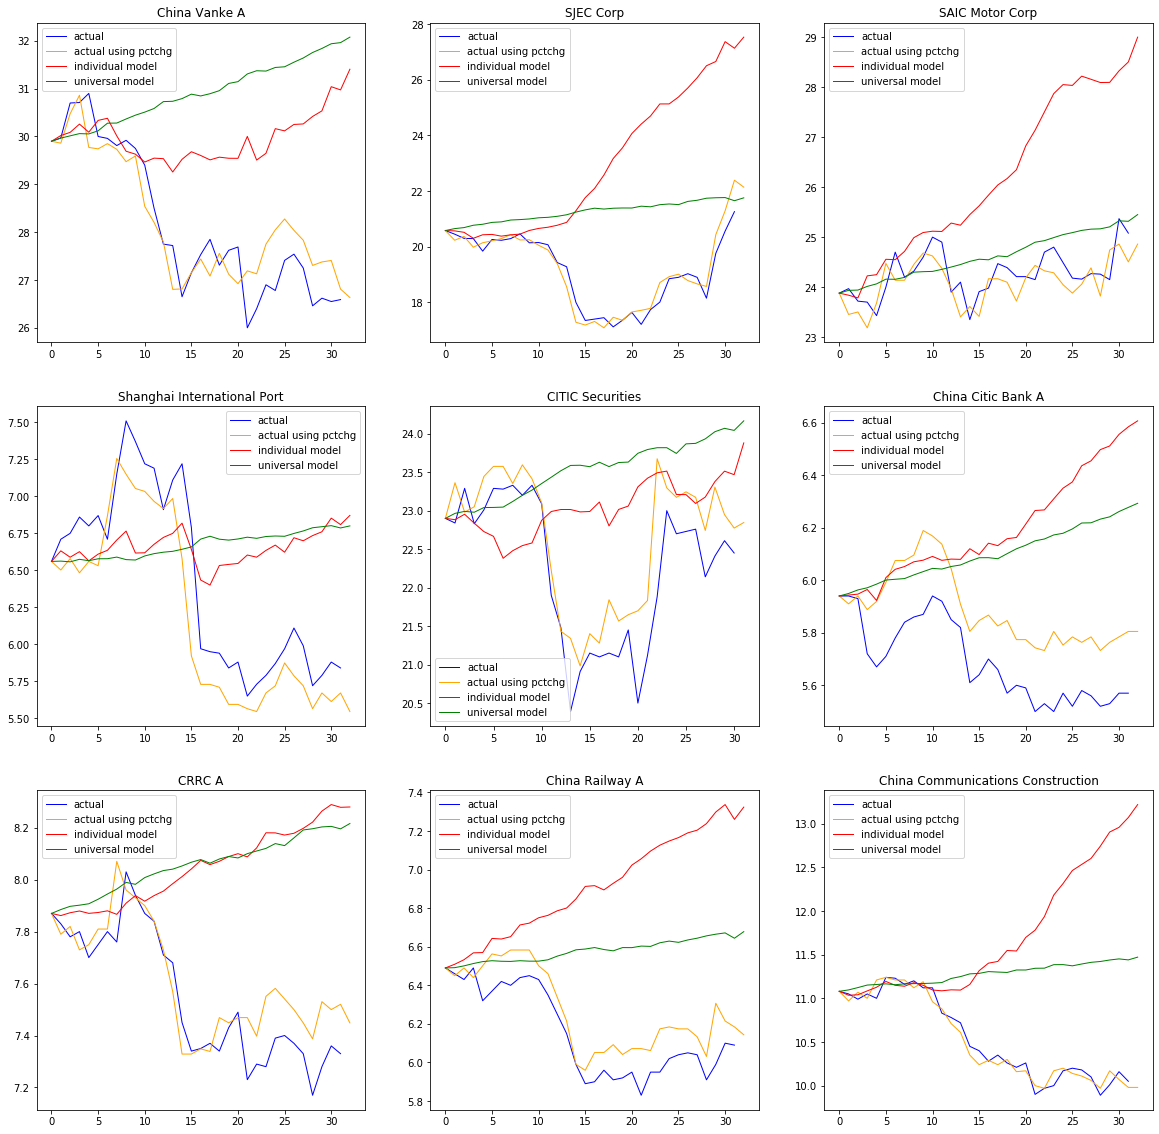

In [162]:
fig, axs = plt.subplots(3,3, figsize=(20,20))

for i in range(9):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    training_size = int(data_i.shape[0] * 0.8)
    actual_price_i = list(data_i.iloc[training_size:].loc[:,'open-1'])
    actual_pctchg_i = list(data_i.iloc[training_size:].loc[:,'pctchg-0'])
    predicted_price_i_i = [actual_price_i[0]]
    predicted_price_i_all = [actual_price_i[0]]
    actual_using_pct_i = [actual_price_i[0]]
    y_pred_i_i, y_pred_i_all, _ = linear_regress_predict(data_i)
    for pctchg in actual_pctchg_i:
        actual_using_pct_i.append(actual_using_pct_i[-1] * (1+(0.01*pctchg)))
    for pctchg in list(y_pred_i_i):
        predicted_price_i_i.append(predicted_price_i_i[-1] * (1+(0.01*pctchg)))
    for pctchg in list(y_pred_i_all):
        predicted_price_i_all.append(predicted_price_i_all[-1] * (1+(0.01*pctchg)))
    axs[int(i/3)][i%3].set_title(stock_names_eng[i])
    axs[int(i/3)][i%3].plot(actual_price_i, linewidth=1, color='blue', label='actual')
    axs[int(i/3)][i%3].plot(actual_using_pct_i, linewidth=1, color='orange', label='actual using pctchg')
    axs[int(i/3)][i%3].plot(predicted_price_i_i, linewidth=1, color='red', label='individual model')
    axs[int(i/3)][i%3].plot(predicted_price_i_all, linewidth=1, color='green', label='universal model')
    axs[int(i/3)][i%3].legend();
    
plt.savefig('fig/8.png')
plt.show();

In [163]:
linear_models = []
market_datas = []

for i in range(50):
    data_i = pd.read_csv('final_dataframe/'+str(i)+'.csv')
    market_datas.append(data_i)
    _, _, model_i = linear_regress_predict(data_i)
    linear_models.append(model_i)

In [166]:
import random
def get_ending_position(x):
    money = 100
    random_money = 100
    days = [day.strftime('%Y%m%d') for day in daterange(date(2019,8,1), date(2019,8,30))]
    for day in days:
        try:
            today_market = [market_datas[i].set_index(market_datas[i].columns[0]).loc[[int(day)], :] for i in range(50)]
            predicted_pctchgs = [linear_models[i].predict(today_market[i].iloc[:,:-1])[0] for i in range(50)]
            bought = sorted(range(50), key=lambda i: predicted_pctchgs[i], reverse=True)[:x]
            random_bought = random.sample(range(0, 50), x)
            actual_pctchgs_for_bought = [today_market[i].iloc[:,-1].values[0] for i in bought]
            actual_pctchgs_for_random = [today_market[i].iloc[:,-1].values[0] for i in random_bought]
            money *= (1 + 0.01 * np.mean(actual_pctchgs_for_bought))
            random_money *= (1 + 0.01 * np.mean(actual_pctchgs_for_random))
        except KeyError:
            pass
    return money, random_money

In [173]:
end_positions = [get_ending_position(x)[0] for x in range(1, 51)]
random_positions = [get_ending_position(x)[1] for x in range(1, 51)]

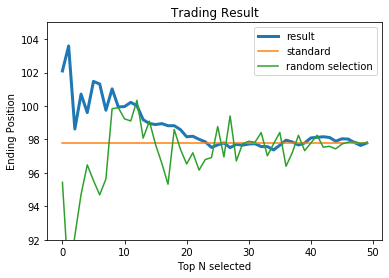

In [176]:
plt.title("Trading Result")
plt.xlabel('Top N selected')
plt.ylabel('Ending Position')
plt.plot(end_positions, linewidth=3, label='result')
plt.plot([end_positions[-1]]*50, label='standard')
plt.plot(random_positions, label='random selection')
plt.ylim((92,105))
plt.legend()
plt.savefig('fig/9.png');

In [100]:
def get_all_positions(x):
    money = [100]
    days = [day.strftime('%Y%m%d') for day in daterange(date(2019,8,1), date(2019,8,30))]
    for day in days:
        try:
            today_market = [market_datas[i].set_index(market_datas[i].columns[0]).loc[[int(day)], :] for i in range(50)]
            predicted_pctchgs = [linear_models[i].predict(today_market[i].iloc[:,:-1])[0] for i in range(50)]
            bought = sorted(range(50), key=lambda i: predicted_pctchgs[i], reverse=True)[:x]
            actual_pctchgs_for_bought = [today_market[i].iloc[:,-1].values[0] for i in bought]
            money.append( money[-1] * (1 + 0.01 * np.mean(actual_pctchgs_for_bought)))
        except KeyError:
            pass
    return money

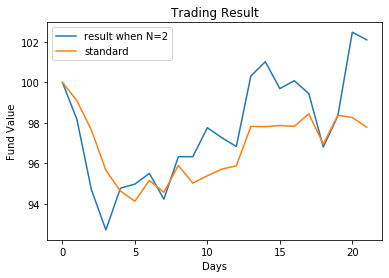

In [102]:
plt.title("Trading Result")
plt.xlabel('Days')
plt.ylabel('Fund Value')
plt.plot(get_all_positions(1), label='result when N=2')
plt.plot(get_all_positions(50), label='standard')
plt.legend();
plt.savefig('fig/10.png')

## 9 - Training and Testing Neural Networks

Now that we have explored much using the simplest linear regression model, we try a basic neural network this time, which should be more sensible since the relationship between news sentiment scores and stock performance is probably non-linear.

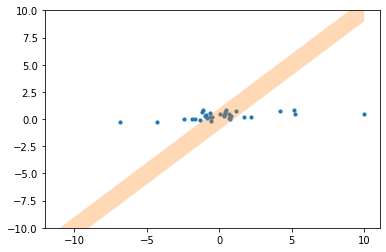

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Activation


data_i = pd.read_csv('final_dataframe/'+str(1)+'.csv')
training_size = int(data_i.shape[0] * 0.8)

training_X_i = data_i.iloc[:training_size, -7:-1]
training_y_i = data_i.iloc[:training_size, -1]
testing_X_i = data_i.iloc[training_size:, -7:-1]
testing_y_i = data_i.iloc[training_size:, -1]

model = Sequential()
model.add(Dense(5, activation='selu'))
model.add(Dense(5, activation='selu'))
model.add(Dense(5, activation='selu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.fit(training_X_i.values, training_y_i.values, verbose=0, batch_size=1000, epochs=100)

plt.scatter(testing_y_i, model.predict(testing_X_i), s=10)
plt.fill_between(range(-11,11), range(-12,10), range(-10,12), alpha=0.3)
plt.ylim((-10,10));